# Exploration.8: 네이버 영화리뷰 감성분석 도전하기
### <루브릭>
1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.  
3가지 이상의 모델이 성공적으로 시도됨  
2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.  
gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함  
3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.  
네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함  

In [1]:
import pandas
import konlpy
import gensim
%matplotlib inline
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os
from konlpy.tag import Mecab
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

## 1) 데이터 준비와 확인

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [6]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균:', np.mean(num_tokens))
print('문장길이 최대:', np.max(num_tokens))
print('문장길이 표준편차:', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens) # 최대 길이
print('pad_sequences maxlen : ', maxlen)
print('wjscp answkddml {}%가 maxlen 설정값 이내에 포함됩니다.'.format(np.sum(num_tokens < max_tokens)/len(num_tokens)))

문장길이 평균: 15.96940191154864
문장길이 최대: 116
문장길이 표준편차: 12.843571191092
pad_sequences maxlen :  41
wjscp answkddml 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다.


In [7]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index['<PAD>'],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

# RNN
## (1) RNN 모델 구성 및 validation set 구성

In [8]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [9]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


## (2) RNN 모델 훈련개시

In [10]:
#모델학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 2s 4ms/step - loss: 0.5676 - accuracy: 0.7485 - val_loss: 0.4055 - val_accuracy: 0.8217
Epoch 2/20
266/266 [==============================] - 1s 3ms/step - loss: 0.3678 - accuracy: 0.8410 - val_loss: 0.3545 - val_accuracy: 0.8414
Epoch 3/20
266/266 [==============================] - 1s 3ms/step - loss: 0.3228 - accuracy: 0.8625 - val_loss: 0.3467 - val_accuracy: 0.8492
Epoch 4/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2971 - accuracy: 0.8756 - val_loss: 0.3479 - val_accuracy: 0.8491
Epoch 5/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2777 - accuracy: 0.8851 - val_loss: 0.3535 - val_accuracy: 0.8477
Epoch 6/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2622 - accuracy: 0.8927 - val_loss: 0.3593 - val_accuracy: 0.8488
Epoch 7/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2492 - accuracy: 0.8983 - val_loss: 0.3681 - val_accuracy: 0.8444
Epoch 

In [11]:
#평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5120 - accuracy: 0.8270
[0.5119776725769043, 0.8270439505577087]


## (3) RNN 모델 Loss, Accuracy 그래프 시각화


In [12]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


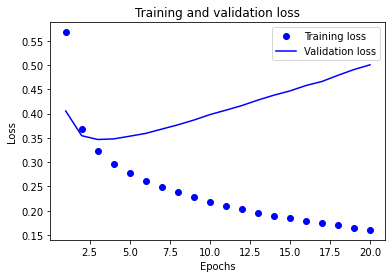

In [13]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

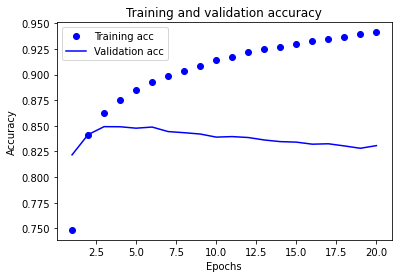

In [14]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## (4) 학습된 RNN 모델 Embedding 레이어 분석

In [15]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [16]:
#with open(word2vec_path, 'r', encoding='utf-8') as f:
#    lines  = f.readlines()

In [17]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [18]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['연기']
vector

array([-0.25286368, -0.19916578,  0.09746639, -0.30675676, -0.27600315,
        0.00647843, -0.06403891, -0.14091179, -0.18867232, -0.01050085,
        0.00166033, -0.25380987, -0.22431697, -0.02601817, -0.03078745,
       -0.2625702 ], dtype=float32)

In [19]:
word_vectors.similar_by_word("연기")

[('아트', 0.9351718425750732),
 ('결심', 0.9305973649024963),
 ('된', 0.9250033497810364),
 ('스타일', 0.909194827079773),
 ('대사', 0.9079586267471313),
 ('주', 0.9012202620506287),
 ('평', 0.9010574817657471),
 ('던데', 0.88924241065979),
 ('읍니다', 0.8881332874298096),
 ('남', 0.8880947232246399)]

# 1-D Convolution Nueral Network(1-D CNN)모델
## (1) 1-D CNN 모델 구성 및 validation set 구성

In [20]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [21]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


## (2) 1-D CNN 모델 훈련 개시

In [22]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 4s 6ms/step - loss: 0.4827 - accuracy: 0.7665 - val_loss: 0.3515 - val_accuracy: 0.8459
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3311 - accuracy: 0.8601 - val_loss: 0.3378 - val_accuracy: 0.8522
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3025 - accuracy: 0.8731 - val_loss: 0.3359 - val_accuracy: 0.8552
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2808 - accuracy: 0.8843 - val_loss: 0.3367 - val_accuracy: 0.8549
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2581 - accuracy: 0.8964 - val_loss: 0.3431 - val_accuracy: 0.8576
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2323 - accuracy: 0.9089 - val_loss: 0.3583 - val_accuracy: 0.8529
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2021 - accuracy: 0.9237 - val_loss: 0.3766 - val_accuracy: 0.8477
Epoch 

In [23]:
#평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.9227 - accuracy: 0.8182
[0.9226612448692322, 0.818235456943512]


 ## (3) 1-D CNN 모델 Loss, Accuracy 그래프 시각화

In [24]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


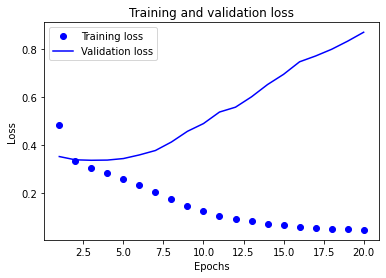

In [25]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

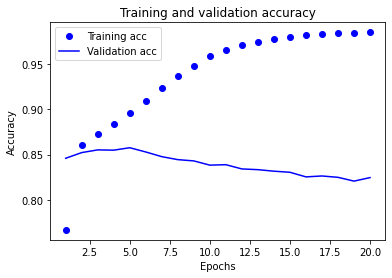

In [26]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## (4) 학습된 1-D CNN 모델 Embedding 레이어 분석

In [27]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [28]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_cnn.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

# LSTM모델
## (1)LSTM 모델 구성 및 validation set 구성

In [29]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계
lstm = keras.Sequential()
lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm.add(keras.layers.LSTM(8))
lstm.add(keras.layers.Dense(8, activation='relu'))
lstm.add(keras.layers.Dense(1, activation='sigmoid'))

lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [30]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


## (2) LSTM 모델 훈련 개시

In [31]:
epochs = 20

lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_lstm = lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 4s 7ms/step - loss: 0.5151 - accuracy: 0.7312 - val_loss: 0.3610 - val_accuracy: 0.8454
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3398 - accuracy: 0.8563 - val_loss: 0.3407 - val_accuracy: 0.8536
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3180 - accuracy: 0.8660 - val_loss: 0.3391 - val_accuracy: 0.8533
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3082 - accuracy: 0.8700 - val_loss: 0.3381 - val_accuracy: 0.8527
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2995 - accuracy: 0.8737 - val_loss: 0.3379 - val_accuracy: 0.8541
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2914 - accuracy: 0.8777 - val_loss: 0.3420 - val_accuracy: 0.8528
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2824 - accuracy: 0.8799 - val_loss: 0.3464 - val_accuracy: 0.8561
Epoch 

In [32]:
#학습이 끝난 모델을 테스트셋으로 평가
results = lstm.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4713 - accuracy: 0.8403
[0.471264511346817, 0.8402668833732605]


## (3) LSTM모델 Loss, Accuracy 그래프 시각화

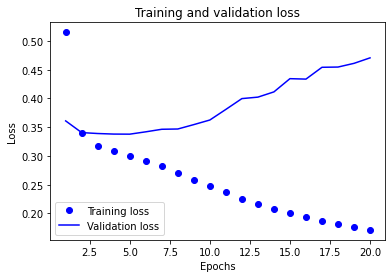

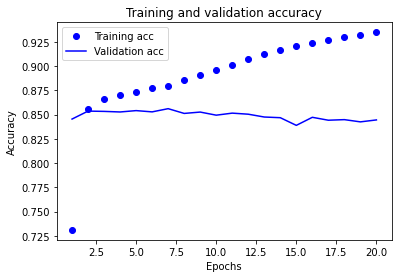

In [33]:
history_dict = history_lstm.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 그림을 초기화
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## (4) 학습된 LSTM모델 Embedding 레이어 분석

In [34]:
embedding_lstm = lstm.layers[0]
weights_lstm = embedding_lstm.get_weights()[0]

In [35]:
word2vec_file_path_lstm = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_lstm.txt'
f = open(word2vec_file_path_lstm, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [36]:
word_vectors_lstm = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_lstm, binary=False)

In [37]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['연기']
vector

array([-0.06240159, -0.06183704, -0.04707424, -0.00963989, -0.00874024,
       -0.01163612,  0.03344787,  0.06969734, -0.01105332,  0.03771776,
        0.0662008 ,  0.00998442, -0.01619436,  0.02919985,  0.02702505,
        0.00443941], dtype=float32)

In [38]:
word_vectors.similar_by_word("연기")

[('8', 0.8516889810562134),
 ('마피아', 0.8044667840003967),
 ('완성', 0.7867658138275146),
 ('알차', 0.7783173322677612),
 ('신하균', 0.7736849784851074),
 ('시네마', 0.77073734998703),
 ('명화', 0.7693758010864258),
 ('추기경', 0.7655898332595825),
 ('ㅑ', 0.7603141069412231),
 ('냉소', 0.7506600022315979)]

## (5) 한국어 Word2Vec 임베딩 활용하여 성능 개선(LSTM모델)

In [39]:
import pprint

path = os.getenv('HOME')+'/data/word2vec_ko.model' 
ko_vec = Word2Vec.load(path)

print(ko_vec.wv["배우"]) # ko_vec["배우"]방식은 deprecated라고 한다.
pprint.pprint(ko_vec.wv.most_similar("배우")) #마찬가지로 ko_vec.most_similar() 방식도 deprecated. 지양하자.

ko_vec = ko_vec.wv # ko_vec.wv대신 ko_vec을 사용하면 아래에서도 deprecated 경고 발생

[-0.58881295 -4.3877287  -3.4858546  -2.3084912   0.87703085  6.4445586
 -1.1062126  -2.2230182  -0.78621733  1.9408462  -1.1357461   1.0119969
 -0.30329964 -5.455517    2.6356647  -5.2909884  -1.744448    2.5409734
  3.716852   -1.4752581  -1.1985137   3.5504315  -0.41522408 -0.2436183
  1.5218438  -3.4603841   1.1120543   0.39729053 -2.707328    1.3680482
 -4.2843776   3.014664    2.6393197   0.9804478  -1.0825127   3.6201363
  3.1546066   0.9634868   1.3677765   0.82937515  1.9380125  -2.6699877
 -0.41389105  2.7402463   3.415545   -0.37949705  4.4021254   1.2531414
  2.504994    0.33631453 -2.0658643  -3.1885884   6.659477   -5.47897
  3.1113489   1.6667893   2.8441331  -1.1597652  -0.19843072 -0.07214008
  0.47545317  4.105001   -0.20690314 -4.399607   -0.32254001  2.030352
  0.35149667 -4.0907154   1.12323    -1.873176    2.422429    1.9751279
 -0.9144355   4.34507    -1.0122209   3.4604955  -2.2505796  -5.2072535
  1.4032923   0.7049264   2.6884458   0.11147156  1.4308741   0.03

In [40]:
vocab_size_ko_vec = 10000
word_vector_dim_ko_vec = 100

embedding_matrix = np.random.rand(vocab_size_ko_vec, word_vector_dim_ko_vec)

for i in range(4,vocab_size_ko_vec):
    if index_to_word[i] in ko_vec:
        embedding_matrix[i] = ko_vec[index_to_word[i]]

In [41]:
vocab_size = 10000
word_vector_dim = 100

# LSTM
lstm = keras.Sequential()
lstm.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
lstm.add(keras.layers.LSTM(128))
lstm.add(keras.layers.Dense(128, activation='relu'))
lstm.add(keras.layers.Dense(1, activation='sigmoid'))

lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 1,133,889
Trainable params: 1,133,889
Non-trainable params: 0
_________________________________________________________________


In [42]:
epochs = 4

lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_lstm = lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/4
266/266 [==============================] - 4s 12ms/step - loss: 0.5558 - accuracy: 0.6824 - val_loss: 0.4162 - val_accuracy: 0.8168
Epoch 2/4
266/266 [==============================] - 3s 10ms/step - loss: 0.3660 - accuracy: 0.8376 - val_loss: 0.3388 - val_accuracy: 0.8517
Epoch 3/4
266/266 [==============================] - 3s 10ms/step - loss: 0.3128 - accuracy: 0.8655 - val_loss: 0.3185 - val_accuracy: 0.8624
Epoch 4/4
266/266 [==============================] - 3s 10ms/step - loss: 0.2808 - accuracy: 0.8813 - val_loss: 0.3104 - val_accuracy: 0.8656


In [43]:
# LSTM
results_lstm = lstm.evaluate(X_test, y_test, verbose=2)
print(results_lstm)

1537/1537 - 3s - loss: 0.3201 - accuracy: 0.8617
[0.320139616727829, 0.8616880774497986]


# 회고
3가지 모델 구현 결과  
- RNN 모델 : 0.8264  
- 1-D Convolution Neural Network(1-D CNN)모델 : 0.8182  
- LSTM 모델 : 0.8321  

3가지 모델 중 가장 성능이 좋은 모델은 LSTM모델이었다. 

- 한국어 Word2Vec을 활용한 LSTM 모델결과 : 0.8617(85%넘기기 성공!)

자연어처리는 아직 너무 어렵게만 느껴진다.